In [1]:
import netsquid as ns
from netsquid.nodes import DirectConnection, Node
from netsquid.components import FibreDelayModel, FibreLossModel, QuantumChannel
from netsquid.components import DepolarNoiseModel, DephaseNoiseModel
from netsquid.protocols import NodeProtocol

In [2]:
class SymmetricDirectConnection(DirectConnection):
    def __init__(self, name, L:int, loss_model, delay_model, noise_model) -> None:
        modelDict = {
                    'quantum_noise_model': noise_model,
                    'quantum_loss_model': loss_model,
                    'delay_model': delay_model
                    }
        abChannel = QuantumChannel("A->B", length=L, models=modelDict)
        baChannel = QuantumChannel("B->A", length=L, models=modelDict)
        super().__init__(name, abChannel, baChannel)

In [3]:
class SendProtocol(NodeProtocol):
    def __init__(self, node):
        super().__init__(node)
        self.qbitSent = 0

    def run(self):
        while not HAS_RECEIVED:
            qubit = ns.qubits.create_qubits(1)[0]
            self.node.ports["qubitIO"].tx_output(qubit)
            self.qbitSent += 1
            # Send (TX) qubit to the other node via port's output:
            # print(
            #     f"[{ns.sim_time(magnitude=ns.MICROSECOND)} μs] {self.node.name} is sending a qubit."
            # )
            yield self.await_timer(1e6)  # wait 1000 μs


class ReceiveProtocol(NodeProtocol):
    def __init__(self, node):
        super().__init__(node)

    def run(self):
        while True:
            # Wait (yield) until input has arrived on our port:
            yield self.await_port_input(self.node.ports["qubitIO"])

            _ = self.node.ports["qubitIO"].rx_input()
            # Receive (RX) qubit on the port's input:
            global HAS_RECEIVED
            HAS_RECEIVED = True

            # Print timestamp of reception:
            current_time = ns.sim_time(magnitude=ns.MICROSECOND)
            # print(f"[{current_time} μs] {self.node.name} received a qubit.")

In [4]:
def create_directConnected_nodes(distance: int, p: list[float], depolar_freq):
    assert len(p) >= 2
    portName = "qubitIO"
    nodeA = Node("nodeA", port_names=[portName])
    nodeB = Node("nodeB", port_names=[portName])
    conn = SymmetricDirectConnection("AB_channel", distance, 
                                     FibreLossModel(p[0], p[1]), FibreDelayModel(), 
                                     DepolarNoiseModel(depolar_freq))
    nodeA.connect_to(remote_node=nodeB, connection=conn,
                        local_port_name=portName, remote_port_name=portName)
    return nodeA, nodeB

In [5]:
results = []

def setup_sim():
    ns.sim_reset()

    node_distance = 22  # in km
    depolar_freq = 5e4  # depolarization frequency
    p_loss_init = 0.2  # initial loss probability
    p_loss_length = 0.2  # loss probability per km
    nodeA, nodeB = create_directConnected_nodes(node_distance, [p_loss_init, p_loss_length], depolar_freq)

    global HAS_RECEIVED
    HAS_RECEIVED = False
    AProtocol = SendProtocol(nodeA)
    BProtocol = ReceiveProtocol(nodeB)

    AProtocol.start()
    BProtocol.start()

    stats:ns.util.SimStats = ns.sim_run(magnitude=ns.MICROSECOND)
    # print(f"Simulation ended at t={ns.sim_time(magnitude=ns.MICROSECOND)} μs | {nodeA.name} sent {AProtocol.qbitSent} qubits")
    # print(stats.summary())
    # print("Raw data dictionary entries:")
    # print(stats.data)
    results.append((ns.sim_time(magnitude=ns.MICROSECOND), AProtocol.qbitSent))

n_runs = 1000

for _ in range(n_runs):
    setup_sim()


In [6]:
# median qubits sent
qsents = sorted([r[1] for r in results])
median_qsents = qsents[len(qsents)//2]
print(f"Median qubits sent over {n_runs} runs: {median_qsents}")

Median qubits sent over 1000 runs: 2


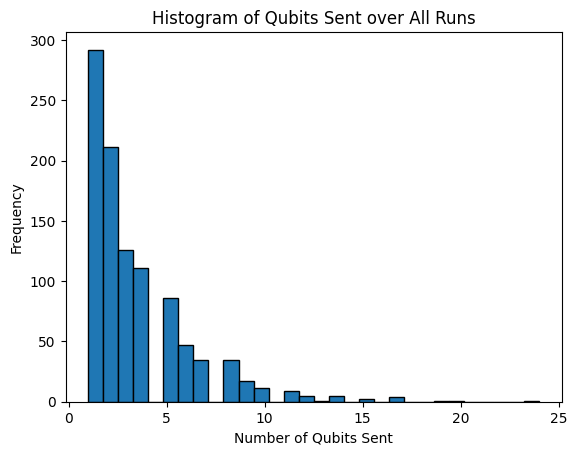

In [7]:
# Plot histogram of qubits sent over all runs
import matplotlib.pyplot as plt
plt.hist([r[1] for r in results], bins=30, edgecolor='black')
plt.title('Histogram of Qubits Sent over All Runs')
plt.xlabel('Number of Qubits Sent')
plt.ylabel('Frequency')
plt.show()